In [13]:
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

batch_size = 3
sentence_max_length = 5
n_features = 2
new_shape = (batch_size, sentence_max_length, n_features)
x = tf.constant(np.reshape(np.arange(30), new_shape), dtype = tf.float32)

lstm_cells = tf.keras.layers.LSTMCell(128)

lstm_cells.get_initial_state(batch_size=1, dtype=tf.float32)

test_input = np.ones((2,128))

states = lstm_cells.get_initial_state(batch_size=1, dtype=tf.float32)
test_output = lstm_cells(test_input, states)
print("test_output: ", test_output)

#rnn_cells = [tf.keras.layers.LSTMCell(128) for _ in range(1)]
#stacked_lstm = tf.keras.layers.StackedRNNCells(rnn_cells)

#initial_state = stacked_lstm.get_initial_state(batch_size=4, dtype=tf.float32)
#initial_state
#lstm_layer = tf.keras.layers.RNN(stacked_lstm)

#result = lstm_layer(x)

test_output:  (<tf.Tensor: shape=(2, 128), dtype=float32, numpy=
array([[ 1.02849394e-01, -3.64125073e-02, -7.51350671e-02,
        -1.42729133e-01,  1.30299643e-01,  3.64783928e-02,
         2.49019876e-01, -5.94914258e-02,  9.30734817e-03,
        -1.45292446e-01,  1.03589945e-01, -1.29420519e-01,
        -8.62171873e-02, -1.51720047e-01, -1.13675460e-01,
        -2.35854089e-01,  2.03298237e-02, -1.40412590e-02,
        -3.29783529e-01, -7.47002615e-03, -1.54086679e-01,
        -1.79020494e-01,  5.61962873e-02,  1.94981415e-02,
        -7.13001266e-02, -2.26844057e-01, -1.43006757e-01,
        -9.67420191e-02, -3.61254299e-03, -1.55159831e-01,
         8.03648606e-02, -2.27837078e-02, -7.00157583e-02,
         2.87210764e-06,  1.35928199e-01,  3.16844927e-03,
        -9.63403359e-02, -5.82029484e-02, -6.96222112e-02,
         2.35813454e-01,  1.81506783e-01,  2.62233261e-02,
         5.87270297e-02, -1.40106037e-01,  2.51356177e-02,
        -1.27384260e-01, -1.21019334e-02,  1.69247

2022-08-18 23:37:26.737929: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-08-18 23:37:29.277260: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-18 23:37:29.278130: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-18 23:37:29.305686: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-18 23:37:29.305722: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: kimbring2-ROG-Strix-GA35DX-G35DX
2022-08-18 23:37:29.305728: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: kimbring2-ROG-Strix-GA35DX-G35DX
2022-08-18 23:37:29.305845: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 

episode: 0/2000000, thread: 0, score: -17.0, average: -17.00 SAVING
episode: 1/2000000, thread: 0, score: -21.0, average: -19.00 
episode: 2/2000000, thread: 0, score: -20.0, average: -19.33 
episode: 3/2000000, thread: 0, score: -20.0, average: -19.50 
episode: 4/2000000, thread: 0, score: -20.0, average: -19.60 
episode: 5/2000000, thread: 0, score: -20.0, average: -19.67 
episode: 6/2000000, thread: 0, score: -20.0, average: -19.71 
episode: 7/2000000, thread: 0, score: -21.0, average: -19.88 
episode: 8/2000000, thread: 0, score: -21.0, average: -20.00 
episode: 9/2000000, thread: 0, score: -20.0, average: -20.00 
episode: 10/2000000, thread: 0, score: -20.0, average: -20.00 
episode: 11/2000000, thread: 0, score: -20.0, average: -20.00 
episode: 12/2000000, thread: 0, score: -20.0, average: -20.00 
episode: 13/2000000, thread: 0, score: -21.0, average: -20.07 
episode: 14/2000000, thread: 0, score: -21.0, average: -20.13 
episode: 15/2000000, thread: 0, score: -20.0, average: -20.

episode: 130/2000000, thread: 0, score: -21.0, average: -20.26 
episode: 131/2000000, thread: 0, score: -20.0, average: -20.26 
episode: 132/2000000, thread: 0, score: -20.0, average: -20.24 
episode: 133/2000000, thread: 0, score: -20.0, average: -20.24 
episode: 134/2000000, thread: 0, score: -20.0, average: -20.22 
episode: 135/2000000, thread: 0, score: -20.0, average: -20.24 
episode: 136/2000000, thread: 0, score: -21.0, average: -20.26 
episode: 137/2000000, thread: 0, score: -19.0, average: -20.24 
episode: 138/2000000, thread: 0, score: -21.0, average: -20.32 
episode: 139/2000000, thread: 0, score: -20.0, average: -20.32 
episode: 140/2000000, thread: 0, score: -21.0, average: -20.32 
episode: 141/2000000, thread: 0, score: -20.0, average: -20.32 
episode: 142/2000000, thread: 0, score: -19.0, average: -20.28 
episode: 143/2000000, thread: 0, score: -19.0, average: -20.26 
episode: 144/2000000, thread: 0, score: -21.0, average: -20.28 
episode: 145/2000000, thread: 0, score: 

episode: 259/2000000, thread: 0, score: -20.0, average: -20.24 
episode: 260/2000000, thread: 0, score: -19.0, average: -20.24 
episode: 261/2000000, thread: 0, score: -21.0, average: -20.24 
episode: 262/2000000, thread: 0, score: -21.0, average: -20.24 
episode: 263/2000000, thread: 0, score: -21.0, average: -20.28 
episode: 264/2000000, thread: 0, score: -21.0, average: -20.28 
episode: 265/2000000, thread: 0, score: -20.0, average: -20.28 
episode: 266/2000000, thread: 0, score: -18.0, average: -20.26 
episode: 267/2000000, thread: 0, score: -21.0, average: -20.28 
episode: 268/2000000, thread: 0, score: -20.0, average: -20.28 
episode: 269/2000000, thread: 0, score: -21.0, average: -20.32 
episode: 270/2000000, thread: 0, score: -19.0, average: -20.28 
episode: 271/2000000, thread: 0, score: -21.0, average: -20.30 
episode: 272/2000000, thread: 0, score: -21.0, average: -20.32 
episode: 273/2000000, thread: 0, score: -20.0, average: -20.32 
episode: 274/2000000, thread: 0, score: 

episode: 388/2000000, thread: 0, score: -20.0, average: -20.22 
episode: 389/2000000, thread: 0, score: -19.0, average: -20.24 
episode: 390/2000000, thread: 0, score: -20.0, average: -20.24 
episode: 391/2000000, thread: 0, score: -19.0, average: -20.20 
episode: 392/2000000, thread: 0, score: -20.0, average: -20.18 
episode: 393/2000000, thread: 0, score: -19.0, average: -20.18 
episode: 394/2000000, thread: 0, score: -19.0, average: -20.14 
episode: 395/2000000, thread: 0, score: -21.0, average: -20.16 
episode: 396/2000000, thread: 0, score: -20.0, average: -20.20 
episode: 397/2000000, thread: 0, score: -21.0, average: -20.22 
episode: 398/2000000, thread: 0, score: -20.0, average: -20.20 
episode: 399/2000000, thread: 0, score: -19.0, average: -20.16 
episode: 400/2000000, thread: 0, score: -20.0, average: -20.14 
episode: 401/2000000, thread: 0, score: -21.0, average: -20.16 
episode: 402/2000000, thread: 0, score: -21.0, average: -20.16 
episode: 403/2000000, thread: 0, score: 

episode: 517/2000000, thread: 0, score: -19.0, average: -20.32 
episode: 518/2000000, thread: 0, score: -20.0, average: -20.30 
episode: 519/2000000, thread: 0, score: -21.0, average: -20.32 
episode: 520/2000000, thread: 0, score: -21.0, average: -20.32 
episode: 521/2000000, thread: 0, score: -21.0, average: -20.32 
episode: 522/2000000, thread: 0, score: -21.0, average: -20.36 
episode: 523/2000000, thread: 0, score: -20.0, average: -20.34 
episode: 524/2000000, thread: 0, score: -20.0, average: -20.32 
episode: 525/2000000, thread: 0, score: -20.0, average: -20.34 
episode: 526/2000000, thread: 0, score: -21.0, average: -20.34 
episode: 527/2000000, thread: 0, score: -21.0, average: -20.34 
episode: 528/2000000, thread: 0, score: -19.0, average: -20.32 
episode: 529/2000000, thread: 0, score: -20.0, average: -20.30 
episode: 530/2000000, thread: 0, score: -21.0, average: -20.32 
episode: 531/2000000, thread: 0, score: -21.0, average: -20.32 
episode: 532/2000000, thread: 0, score: 

episode: 646/2000000, thread: 0, score: -21.0, average: -20.52 
episode: 647/2000000, thread: 0, score: -21.0, average: -20.54 
episode: 648/2000000, thread: 0, score: -21.0, average: -20.54 
episode: 649/2000000, thread: 0, score: -21.0, average: -20.54 
episode: 650/2000000, thread: 0, score: -21.0, average: -20.56 
episode: 651/2000000, thread: 0, score: -21.0, average: -20.58 
episode: 652/2000000, thread: 0, score: -20.0, average: -20.56 
episode: 653/2000000, thread: 0, score: -21.0, average: -20.56 
episode: 654/2000000, thread: 0, score: -20.0, average: -20.56 
episode: 655/2000000, thread: 0, score: -21.0, average: -20.56 
episode: 656/2000000, thread: 0, score: -19.0, average: -20.52 
episode: 657/2000000, thread: 0, score: -20.0, average: -20.50 
episode: 658/2000000, thread: 0, score: -21.0, average: -20.52 
episode: 659/2000000, thread: 0, score: -18.0, average: -20.46 
episode: 660/2000000, thread: 0, score: -20.0, average: -20.44 
episode: 661/2000000, thread: 0, score: 

episode: 775/2000000, thread: 0, score: -21.0, average: -20.00 
episode: 776/2000000, thread: 0, score: -20.0, average: -19.98 
episode: 777/2000000, thread: 0, score: -18.0, average: -19.96 
episode: 778/2000000, thread: 0, score: -20.0, average: -19.94 
episode: 779/2000000, thread: 0, score: -21.0, average: -19.96 
episode: 780/2000000, thread: 0, score: -20.0, average: -19.94 
episode: 781/2000000, thread: 0, score: -21.0, average: -20.00 
episode: 782/2000000, thread: 0, score: -21.0, average: -20.02 
episode: 783/2000000, thread: 0, score: -20.0, average: -20.02 
episode: 784/2000000, thread: 0, score: -20.0, average: -20.00 
episode: 785/2000000, thread: 0, score: -21.0, average: -20.00 
episode: 786/2000000, thread: 0, score: -20.0, average: -19.98 
episode: 787/2000000, thread: 0, score: -21.0, average: -19.98 
episode: 788/2000000, thread: 0, score: -19.0, average: -19.98 
episode: 789/2000000, thread: 0, score: -21.0, average: -20.00 
episode: 790/2000000, thread: 0, score: 

episode: 904/2000000, thread: 0, score: -20.0, average: -20.10 
episode: 905/2000000, thread: 0, score: -19.0, average: -20.06 
episode: 906/2000000, thread: 0, score: -20.0, average: -20.06 
episode: 907/2000000, thread: 0, score: -21.0, average: -20.10 
episode: 908/2000000, thread: 0, score: -19.0, average: -20.06 
episode: 909/2000000, thread: 0, score: -20.0, average: -20.06 
episode: 910/2000000, thread: 0, score: -21.0, average: -20.08 
episode: 911/2000000, thread: 0, score: -20.0, average: -20.06 
episode: 912/2000000, thread: 0, score: -19.0, average: -20.06 
episode: 913/2000000, thread: 0, score: -19.0, average: -20.06 
episode: 914/2000000, thread: 0, score: -19.0, average: -20.04 
episode: 915/2000000, thread: 0, score: -21.0, average: -20.08 
episode: 916/2000000, thread: 0, score: -20.0, average: -20.08 
episode: 917/2000000, thread: 0, score: -21.0, average: -20.08 
episode: 918/2000000, thread: 0, score: -20.0, average: -20.08 
episode: 919/2000000, thread: 0, score: 

episode: 1032/2000000, thread: 0, score: -19.0, average: -20.20 
episode: 1033/2000000, thread: 0, score: -20.0, average: -20.18 
episode: 1034/2000000, thread: 0, score: -20.0, average: -20.16 
episode: 1035/2000000, thread: 0, score: -20.0, average: -20.16 
episode: 1036/2000000, thread: 0, score: -21.0, average: -20.16 
episode: 1037/2000000, thread: 0, score: -21.0, average: -20.18 
episode: 1038/2000000, thread: 0, score: -19.0, average: -20.14 
episode: 1039/2000000, thread: 0, score: -20.0, average: -20.16 
episode: 1040/2000000, thread: 0, score: -21.0, average: -20.16 
episode: 1041/2000000, thread: 0, score: -20.0, average: -20.18 
episode: 1042/2000000, thread: 0, score: -21.0, average: -20.18 
episode: 1043/2000000, thread: 0, score: -20.0, average: -20.18 
episode: 1044/2000000, thread: 0, score: -21.0, average: -20.18 
episode: 1045/2000000, thread: 0, score: -21.0, average: -20.24 
episode: 1046/2000000, thread: 0, score: -21.0, average: -20.26 
episode: 1047/2000000, th

episode: 1159/2000000, thread: 0, score: -20.0, average: -20.44 
episode: 1160/2000000, thread: 0, score: -21.0, average: -20.46 
episode: 1161/2000000, thread: 0, score: -18.0, average: -20.40 
episode: 1162/2000000, thread: 0, score: -19.0, average: -20.40 
episode: 1163/2000000, thread: 0, score: -21.0, average: -20.40 
episode: 1164/2000000, thread: 0, score: -20.0, average: -20.40 
episode: 1165/2000000, thread: 0, score: -21.0, average: -20.40 
episode: 1166/2000000, thread: 0, score: -19.0, average: -20.36 
episode: 1167/2000000, thread: 0, score: -20.0, average: -20.34 
episode: 1168/2000000, thread: 0, score: -21.0, average: -20.36 
episode: 1169/2000000, thread: 0, score: -21.0, average: -20.36 
episode: 1170/2000000, thread: 0, score: -20.0, average: -20.34 
episode: 1171/2000000, thread: 0, score: -20.0, average: -20.32 
episode: 1172/2000000, thread: 0, score: -21.0, average: -20.36 
episode: 1173/2000000, thread: 0, score: -21.0, average: -20.38 
episode: 1174/2000000, th

episode: 1286/2000000, thread: 0, score: -21.0, average: -20.22 
episode: 1287/2000000, thread: 0, score: -21.0, average: -20.22 
episode: 1288/2000000, thread: 0, score: -20.0, average: -20.22 
episode: 1289/2000000, thread: 0, score: -21.0, average: -20.22 
episode: 1290/2000000, thread: 0, score: -21.0, average: -20.26 
episode: 1291/2000000, thread: 0, score: -20.0, average: -20.24 
episode: 1292/2000000, thread: 0, score: -20.0, average: -20.22 
episode: 1293/2000000, thread: 0, score: -18.0, average: -20.18 
episode: 1294/2000000, thread: 0, score: -21.0, average: -20.18 
episode: 1295/2000000, thread: 0, score: -21.0, average: -20.18 
episode: 1296/2000000, thread: 0, score: -20.0, average: -20.18 
episode: 1297/2000000, thread: 0, score: -21.0, average: -20.18 
episode: 1298/2000000, thread: 0, score: -21.0, average: -20.20 
episode: 1299/2000000, thread: 0, score: -20.0, average: -20.20 
episode: 1300/2000000, thread: 0, score: -20.0, average: -20.20 
episode: 1301/2000000, th

episode: 1413/2000000, thread: 0, score: -21.0, average: -20.28 
episode: 1414/2000000, thread: 0, score: -20.0, average: -20.28 
episode: 1415/2000000, thread: 0, score: -20.0, average: -20.28 
episode: 1416/2000000, thread: 0, score: -21.0, average: -20.28 
episode: 1417/2000000, thread: 0, score: -20.0, average: -20.28 
episode: 1418/2000000, thread: 0, score: -20.0, average: -20.26 
episode: 1419/2000000, thread: 0, score: -21.0, average: -20.28 
episode: 1420/2000000, thread: 0, score: -21.0, average: -20.28 
episode: 1421/2000000, thread: 0, score: -18.0, average: -20.22 
episode: 1422/2000000, thread: 0, score: -21.0, average: -20.24 
episode: 1423/2000000, thread: 0, score: -21.0, average: -20.24 
episode: 1424/2000000, thread: 0, score: -21.0, average: -20.24 
episode: 1425/2000000, thread: 0, score: -21.0, average: -20.28 
episode: 1426/2000000, thread: 0, score: -20.0, average: -20.28 
episode: 1427/2000000, thread: 0, score: -21.0, average: -20.28 
episode: 1428/2000000, th

episode: 1540/2000000, thread: 0, score: -21.0, average: -20.26 
episode: 1541/2000000, thread: 0, score: -21.0, average: -20.26 
episode: 1542/2000000, thread: 0, score: -21.0, average: -20.28 
episode: 1543/2000000, thread: 0, score: -19.0, average: -20.26 
episode: 1544/2000000, thread: 0, score: -21.0, average: -20.28 
episode: 1545/2000000, thread: 0, score: -20.0, average: -20.26 
episode: 1546/2000000, thread: 0, score: -20.0, average: -20.24 
episode: 1547/2000000, thread: 0, score: -21.0, average: -20.28 
episode: 1548/2000000, thread: 0, score: -21.0, average: -20.30 
episode: 1549/2000000, thread: 0, score: -21.0, average: -20.34 
episode: 1550/2000000, thread: 0, score: -21.0, average: -20.36 
episode: 1551/2000000, thread: 0, score: -21.0, average: -20.38 
episode: 1552/2000000, thread: 0, score: -21.0, average: -20.40 
episode: 1553/2000000, thread: 0, score: -20.0, average: -20.38 
episode: 1554/2000000, thread: 0, score: -19.0, average: -20.34 
episode: 1555/2000000, th

episode: 1667/2000000, thread: 0, score: -20.0, average: -20.22 
episode: 1668/2000000, thread: 0, score: -20.0, average: -20.20 
episode: 1669/2000000, thread: 0, score: -18.0, average: -20.16 
episode: 1670/2000000, thread: 0, score: -18.0, average: -20.12 
episode: 1671/2000000, thread: 0, score: -21.0, average: -20.12 
episode: 1672/2000000, thread: 0, score: -19.0, average: -20.08 
episode: 1673/2000000, thread: 0, score: -20.0, average: -20.06 
episode: 1674/2000000, thread: 0, score: -20.0, average: -20.06 
episode: 1675/2000000, thread: 0, score: -21.0, average: -20.06 
episode: 1676/2000000, thread: 0, score: -20.0, average: -20.04 
episode: 1677/2000000, thread: 0, score: -21.0, average: -20.04 
episode: 1678/2000000, thread: 0, score: -19.0, average: -20.02 
episode: 1679/2000000, thread: 0, score: -19.0, average: -20.00 
episode: 1680/2000000, thread: 0, score: -20.0, average: -19.98 
episode: 1681/2000000, thread: 0, score: -21.0, average: -19.98 
episode: 1682/2000000, th

episode: 1794/2000000, thread: 0, score: -21.0, average: -20.12 
episode: 1795/2000000, thread: 0, score: -20.0, average: -20.12 
episode: 1796/2000000, thread: 0, score: -20.0, average: -20.14 
episode: 1797/2000000, thread: 0, score: -21.0, average: -20.14 
episode: 1798/2000000, thread: 0, score: -21.0, average: -20.14 
episode: 1799/2000000, thread: 0, score: -21.0, average: -20.16 
episode: 1800/2000000, thread: 0, score: -21.0, average: -20.20 
episode: 1801/2000000, thread: 0, score: -18.0, average: -20.18 
episode: 1802/2000000, thread: 0, score: -20.0, average: -20.18 
episode: 1803/2000000, thread: 0, score: -20.0, average: -20.16 
episode: 1804/2000000, thread: 0, score: -21.0, average: -20.20 
episode: 1805/2000000, thread: 0, score: -20.0, average: -20.20 
episode: 1806/2000000, thread: 0, score: -21.0, average: -20.20 
episode: 1807/2000000, thread: 0, score: -21.0, average: -20.20 
episode: 1808/2000000, thread: 0, score: -20.0, average: -20.18 
episode: 1809/2000000, th

episode: 1921/2000000, thread: 0, score: -21.0, average: -20.44 
episode: 1922/2000000, thread: 0, score: -21.0, average: -20.44 
episode: 1923/2000000, thread: 0, score: -21.0, average: -20.46 
episode: 1924/2000000, thread: 0, score: -20.0, average: -20.46 
episode: 1925/2000000, thread: 0, score: -21.0, average: -20.46 
episode: 1926/2000000, thread: 0, score: -21.0, average: -20.48 
episode: 1927/2000000, thread: 0, score: -21.0, average: -20.50 
episode: 1928/2000000, thread: 0, score: -19.0, average: -20.46 
episode: 1929/2000000, thread: 0, score: -20.0, average: -20.46 
episode: 1930/2000000, thread: 0, score: -20.0, average: -20.46 
episode: 1931/2000000, thread: 0, score: -21.0, average: -20.52 
episode: 1932/2000000, thread: 0, score: -20.0, average: -20.52 
episode: 1933/2000000, thread: 0, score: -20.0, average: -20.52 
episode: 1934/2000000, thread: 0, score: -21.0, average: -20.52 
episode: 1935/2000000, thread: 0, score: -21.0, average: -20.52 
episode: 1936/2000000, th

episode: 2048/2000000, thread: 0, score: -21.0, average: -20.22 
episode: 2049/2000000, thread: 0, score: -18.0, average: -20.18 
episode: 2050/2000000, thread: 0, score: -21.0, average: -20.24 
episode: 2051/2000000, thread: 0, score: -20.0, average: -20.26 
episode: 2052/2000000, thread: 0, score: -21.0, average: -20.30 
episode: 2053/2000000, thread: 0, score: -19.0, average: -20.30 
episode: 2054/2000000, thread: 0, score: -20.0, average: -20.28 
episode: 2055/2000000, thread: 0, score: -21.0, average: -20.30 
episode: 2056/2000000, thread: 0, score: -18.0, average: -20.24 
episode: 2057/2000000, thread: 0, score: -20.0, average: -20.22 
episode: 2058/2000000, thread: 0, score: -18.0, average: -20.22 
episode: 2059/2000000, thread: 0, score: -20.0, average: -20.20 
episode: 2060/2000000, thread: 0, score: -19.0, average: -20.18 
episode: 2061/2000000, thread: 0, score: -20.0, average: -20.16 
episode: 2062/2000000, thread: 0, score: -19.0, average: -20.12 
episode: 2063/2000000, th

episode: 2175/2000000, thread: 0, score: -20.0, average: -20.14 
episode: 2176/2000000, thread: 0, score: -20.0, average: -20.14 
episode: 2177/2000000, thread: 0, score: -20.0, average: -20.18 
episode: 2178/2000000, thread: 0, score: -19.0, average: -20.16 
episode: 2179/2000000, thread: 0, score: -21.0, average: -20.18 
episode: 2180/2000000, thread: 0, score: -21.0, average: -20.20 
episode: 2181/2000000, thread: 0, score: -21.0, average: -20.22 
episode: 2182/2000000, thread: 0, score: -21.0, average: -20.24 
episode: 2183/2000000, thread: 0, score: -21.0, average: -20.28 
episode: 2184/2000000, thread: 0, score: -20.0, average: -20.26 
episode: 2185/2000000, thread: 0, score: -20.0, average: -20.28 
episode: 2186/2000000, thread: 0, score: -20.0, average: -20.26 
episode: 2187/2000000, thread: 0, score: -21.0, average: -20.26 
episode: 2188/2000000, thread: 0, score: -21.0, average: -20.28 
episode: 2189/2000000, thread: 0, score: -21.0, average: -20.28 
episode: 2190/2000000, th

episode: 2302/2000000, thread: 0, score: -18.0, average: -20.10 
episode: 2303/2000000, thread: 0, score: -20.0, average: -20.08 
episode: 2304/2000000, thread: 0, score: -20.0, average: -20.08 
episode: 2305/2000000, thread: 0, score: -19.0, average: -20.06 
episode: 2306/2000000, thread: 0, score: -21.0, average: -20.06 
episode: 2307/2000000, thread: 0, score: -20.0, average: -20.06 
episode: 2308/2000000, thread: 0, score: -20.0, average: -20.06 
episode: 2309/2000000, thread: 0, score: -20.0, average: -20.06 
episode: 2310/2000000, thread: 0, score: -21.0, average: -20.10 
episode: 2311/2000000, thread: 0, score: -21.0, average: -20.12 
episode: 2312/2000000, thread: 0, score: -20.0, average: -20.10 
episode: 2313/2000000, thread: 0, score: -20.0, average: -20.10 
episode: 2314/2000000, thread: 0, score: -21.0, average: -20.10 
episode: 2315/2000000, thread: 0, score: -21.0, average: -20.12 
episode: 2316/2000000, thread: 0, score: -20.0, average: -20.16 
episode: 2317/2000000, th

episode: 2429/2000000, thread: 0, score: -21.0, average: -20.06 
episode: 2430/2000000, thread: 0, score: -20.0, average: -20.06 
episode: 2431/2000000, thread: 0, score: -20.0, average: -20.06 
episode: 2432/2000000, thread: 0, score: -21.0, average: -20.06 
episode: 2433/2000000, thread: 0, score: -19.0, average: -20.02 
episode: 2434/2000000, thread: 0, score: -21.0, average: -20.02 
episode: 2435/2000000, thread: 0, score: -21.0, average: -20.02 
episode: 2436/2000000, thread: 0, score: -21.0, average: -20.04 
episode: 2437/2000000, thread: 0, score: -21.0, average: -20.04 
episode: 2438/2000000, thread: 0, score: -21.0, average: -20.04 
episode: 2439/2000000, thread: 0, score: -20.0, average: -20.04 
episode: 2440/2000000, thread: 0, score: -21.0, average: -20.04 
episode: 2441/2000000, thread: 0, score: -20.0, average: -20.04 
episode: 2442/2000000, thread: 0, score: -20.0, average: -20.02 
episode: 2443/2000000, thread: 0, score: -21.0, average: -20.06 
episode: 2444/2000000, th

episode: 2556/2000000, thread: 0, score: -19.0, average: -20.30 
episode: 2557/2000000, thread: 0, score: -20.0, average: -20.28 
episode: 2558/2000000, thread: 0, score: -19.0, average: -20.24 
episode: 2559/2000000, thread: 0, score: -20.0, average: -20.28 
episode: 2560/2000000, thread: 0, score: -19.0, average: -20.28 
episode: 2561/2000000, thread: 0, score: -21.0, average: -20.30 
episode: 2562/2000000, thread: 0, score: -19.0, average: -20.28 
episode: 2563/2000000, thread: 0, score: -20.0, average: -20.30 
episode: 2564/2000000, thread: 0, score: -19.0, average: -20.26 
episode: 2565/2000000, thread: 0, score: -20.0, average: -20.26 
episode: 2566/2000000, thread: 0, score: -19.0, average: -20.24 
episode: 2567/2000000, thread: 0, score: -20.0, average: -20.22 
episode: 2568/2000000, thread: 0, score: -20.0, average: -20.24 
episode: 2569/2000000, thread: 0, score: -20.0, average: -20.24 
episode: 2570/2000000, thread: 0, score: -21.0, average: -20.28 
episode: 2571/2000000, th

KeyboardInterrupt: 

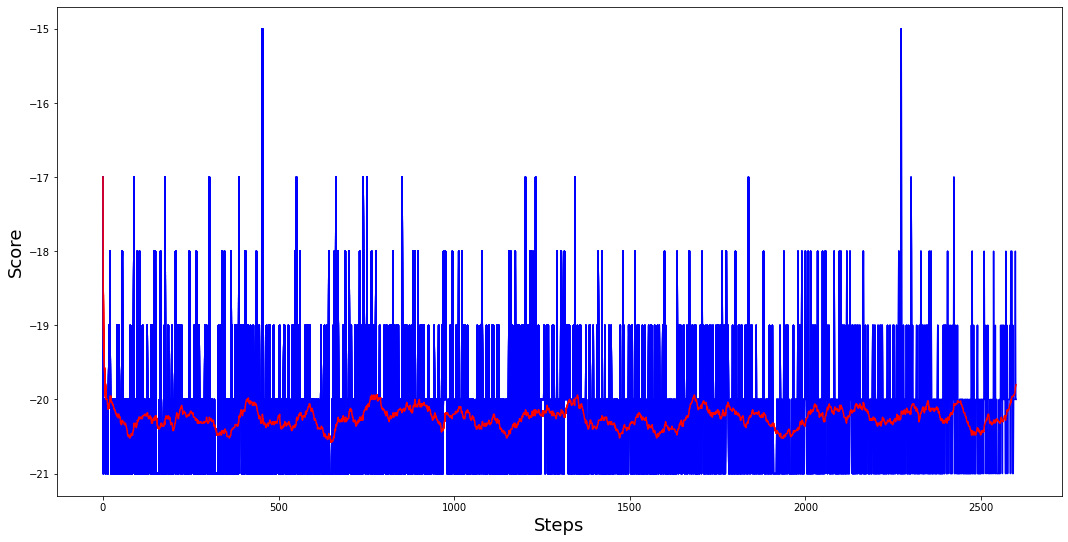

In [1]:
import os
import random
import gym
import pylab
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Lambda, Add, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import cv2
import threading
from threading import Thread, Lock
import time
import tensorflow_probability as tfp
from typing import Any, List, Sequence, Tuple

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

tfd = tfp.distributions


class OurModel(tf.keras.Model):
    def __init__(self, input_shape, action_space):
        super(OurModel, self).__init__()
        
        self.dense_0 = Dense(512, activation='relu')
        
        self.core = tf.keras.layers.LSTMCell(128)
        
        self.dense_1 = Dense(action_space)
        self.dense_2 = Dense(1)
    
    def initial_state(self, batch_size):
        return self.core.get_initial_state(batch_size=batch_size, dtype=tf.float32) 
    
    def call(self, X_input, core_state):
        # X_input.shape:  (1, 4, 80, 80)
        
        batch_size = X_input.shape[0]
        #print("batch_size: ", batch_size)
        #print("core_state: ", core_state)
        
        core_output_list = []
        for i in tf.range(0, batch_size):
            #X_input.shape:  (1, 4, 80, 80)
            #batch_size:  1
            #X_input[i].shape:  (4, 80, 80)
            #Input.shape:  (4, 512)
            #print("X_input[i].shape: ", X_input[i].shape)
            
            Input = tf.expand_dims(X_input[i], 0)
            
            Input = Flatten()(Input)
            #print("Input.shape 1: ", Input.shape)
            
            Input = self.dense_0(Input)
            #print("Input.shape 2: ", Input.shape)
            
            core_output, core_state = self.core(Input, core_state)
            #core_output_flattened = Flatten()(core_output)
            #print("core_output.shape: ", core_output.shape)
            core_output_list.append(core_output)
        
        outputs = tf.stack(core_output_list)
        #print("outputs.shape: ", outputs.shape)
        
        Ouput = Flatten()(outputs)
        #print("Ouput.shape: ", Ouput.shape)
        
        #Ouput = self.dense_0(Ouput)
        action_logit = self.dense_1(Ouput)
        value = self.dense_2(Ouput)
        
        #print("core_state output: ", core_state)
        
        return action_logit, value, core_state


def safe_log(x):
  """Computes a safe logarithm which returns 0 if x is zero."""
  return tf.where(
      tf.math.equal(x, 0),
      tf.zeros_like(x),
      tf.math.log(tf.math.maximum(1e-12, x)))


def take_vector_elements(vectors, indices):
    """
    For a batch of vectors, take a single vector component
    out of each vector.
    Args:
      vectors: a [batch x dims] Tensor.
      indices: an int32 Tensor with `batch` entries.
    Returns:
      A Tensor with `batch` entries, one for each vector.
    """
    return tf.gather_nd(vectors, tf.stack([tf.range(tf.shape(vectors)[0]), indices], axis=1))


huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)
sparse_ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.SUM)
mse_loss = tf.keras.losses.MeanSquaredError()


class A3CAgent:
    # Actor-Critic Main Optimization Algorithm
    def __init__(self, env_name):
        # Initialization
        self.env_name = env_name       
        self.env = gym.make(env_name)
        self.action_size = self.env.action_space.n
        self.EPISODES, self.episode, self.max_average = 2000000, 0, -21.0 # specific for pong
        self.lock = Lock()
        self.lr = 0.0003

        self.ROWS = 80
        self.COLS = 80
        self.REM_STEP = 4

        # Instantiate plot memory
        self.scores, self.episodes, self.average = [], [], []

        self.Save_Path = 'Models'
        self.state_size = (self.REM_STEP, self.ROWS, self.COLS)
        
        if not os.path.exists(self.Save_Path): os.makedirs(self.Save_Path)
        self.path = '{}_A3C_{}'.format(self.env_name, self.lr)
        self.model_name = os.path.join(self.Save_Path, self.path)

        # Create Actor-Critic network model
        self.ActorCritic = OurModel(input_shape=self.state_size, action_space=self.action_size)
        
        #self.optimizer = tf.keras.optimizers.Adam(self.lr)
        self.optimizer = tf.keras.optimizers.RMSprop(learning_rate=self.lr, 
                                                     rho=0.99, momentum=0.0, epsilon=0.1)

    def act(self, state, core_state):
        # Use the network to predict the next action to take, using the model
        prediction = self.ActorCritic(state, core_state, training=False)
        action = tf.random.categorical(prediction[0], 1).numpy()

        return action[0][0], prediction[2]

    def discount_rewards(self, reward, dones):
        # Compute the gamma-discounted rewards over an episode
        gamma = 0.99    # discount rate
        running_add = 0
        discounted_r = np.zeros_like(reward)
        for i in reversed(range(0, len(reward))):
            if reward[i] != 0: # reset the sum, since this was a game boundary (pong specific!)
                running_add = 0

            running_add = running_add * gamma + reward[i]
            discounted_r[i] = running_add

        discounted_r -= np.mean(discounted_r) # normalizing the result
        discounted_r /= np.std(discounted_r) # divide by standard deviation

        return discounted_r
        
    def replay(self, states, actions, rewards, dones):
        # reshape memory to appropriate shape for training
        states = np.vstack(states)
        
        # Compute discounted rewards
        discounted_r = self.discount_rewards(rewards, dones)
        discounted_r_ = np.vstack(discounted_r)
        with tf.GradientTape() as tape:
            core_state = self.ActorCritic.initial_state(1)
            prediction = self.ActorCritic(states, core_state, training=True)
            action_logits = prediction[0]
            values = prediction[1]
            
            action_logits_selected = take_vector_elements(action_logits, actions)
            
            advantages = discounted_r - np.stack(values)[:, 0] 
            
            action_logits_selected = tf.nn.softmax(action_logits_selected)
            action_logits_selected_probs = tf.math.log(action_logits_selected)
            
            action_logits_ = tf.nn.softmax(action_logits)
            dist = tfd.Categorical(probs=action_logits_)
            action_log_prob = dist.prob(actions)
            action_log_prob = tf.math.log(action_log_prob)
            
            actor_loss = -tf.math.reduce_mean(action_logits_selected_probs * advantages) 
            
            action_probs = tf.nn.softmax(action_logits)
            
            critic_loss_ = huber_loss(values, discounted_r)
            critic_loss = mse_loss(values, discounted_r_)
            critic_loss = tf.cast(critic_loss, 'float32')
            
            total_loss = actor_loss + critic_loss
        
        #print("total_loss: ", total_loss)
        #print("")
            
        grads = tape.gradient(total_loss, self.ActorCritic.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.ActorCritic.trainable_variables))
        
    def load(self, model_name):
        self.ActorCritic = load_model(model_name, compile=False)

    def save(self):
        self.ActorCritic.save(self.model_name)

    pylab.figure(figsize=(18, 9))
    def PlotModel(self, score, episode):
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores[-50:]) / len(self.scores[-50:]))
        if str(episode)[-2:] == "00":# much faster than episode % 100
            pylab.plot(self.episodes, self.scores, 'b')
            pylab.plot(self.episodes, self.average, 'r')
            pylab.ylabel('Score', fontsize=18)
            pylab.xlabel('Steps', fontsize=18)
            try:
                pylab.savefig(self.path + ".png")
            except OSError:
                pass

        return self.average[-1]
    
    def imshow(self, image, rem_step=0):
        cv2.imshow(self.model_name + str(rem_step), image[rem_step,...])
        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
            return

    def GetImage(self, frame, image_memory):
        if image_memory.shape == (1,*self.state_size):
            image_memory = np.squeeze(image_memory)
            
        # croping frame to 80x80 size
        frame_cropped = frame[35:195:2, ::2,:]
        if frame_cropped.shape[0] != self.COLS or frame_cropped.shape[1] != self.ROWS:
            # OpenCV resize function 
            frame_cropped = cv2.resize(frame, (self.COLS, self.ROWS), interpolation=cv2.INTER_CUBIC)
        
        # converting to RGB (numpy way)
        frame_rgb = 0.299*frame_cropped[:,:,0] + 0.587*frame_cropped[:,:,1] + 0.114*frame_cropped[:,:,2]

        # convert everything to black and white (agent will train faster)
        frame_rgb[frame_rgb < 100] = 0
        frame_rgb[frame_rgb >= 100] = 255
        
        # dividing by 255 we expresses value to 0-1 representation
        new_frame = np.array(frame_rgb).astype(np.float32) / 255.0

        # push our data by 1 frame, similar as deq() function work
        #image_memory = np.roll(image_memory, 1, axis = 0)

        # inserting new frame to free space
        #image_memory[0,:,:] = new_frame

        #return np.expand_dims(image_memory, axis=0)
        return np.expand_dims(new_frame, axis=0)

    def reset(self, env):
        image_memory = np.zeros(self.state_size)
        frame = env.reset()
        #for i in range(self.REM_STEP):
        #    state = self.GetImage(frame, image_memory)
        state = self.GetImage(frame, image_memory)
            
        return state
    
    def step(self, action, env, image_memory):
        next_frame, reward, done, info = env.step(action)
        next_state = self.GetImage(next_frame, image_memory)
        
        return next_state, reward, done, info
    
    def train(self, n_threads):
        self.env.close()
        # Instantiate one environment per thread
        envs = [gym.make(self.env_name) for i in range(n_threads)]

        # Create threads
        threads = [threading.Thread(
                target=self.train_threading,
                daemon=True,
                args=(self,
                    envs[i],
                    i)) for i in range(n_threads)]

        for t in threads:
            time.sleep(2)
            t.start()
            
        for t in threads:
            time.sleep(10)
            t.join()
            
    def train_threading(self, agent, env, thread):
        while self.episode < self.EPISODES:
            # Reset episode
            score, done, SAVING = 0, False, ''
            state = self.reset(env)
            
            states, actions, rewards, dones = [], [], [], []
            core_state = self.ActorCritic.initial_state(1)
            while not done:
                action, core_state = agent.act(state, core_state)
                next_state, reward, done, _ = self.step(action, env, state)
                
                #print("next_state.shape: ", next_state.shape)
                #print("action: ", action)
                #print("reward: ", reward)
                #print("done: ", done)
                
                states.append(state)
                actions.append(action)
                rewards.append(reward)
                dones.append(done)

                score += reward
                state = next_state
                    
            self.lock.acquire()
            self.replay(states, actions, rewards, dones)
            self.lock.release()
            
            states, actions, rewards, dones = [], [], [], []
                    
            # Update episode count
            with self.lock:
                average = self.PlotModel(score, self.episode)
                # saving best models
                if average >= self.max_average:
                    self.max_average = average
                    #self.save()
                    SAVING = "SAVING"
                else:
                    SAVING = ""

                print("episode: {}/{}, thread: {}, score: {}, average: {:.2f} {}".format(self.episode, self.EPISODES, thread, score, average, SAVING))
                if(self.episode < self.EPISODES):
                    self.episode += 1

        env.close()            

    def test(self, Actor_name, Critic_name):
        self.load(Actor_name, Critic_name)
        for e in range(100):
            state = self.reset(self.env)
            done = False
            score = 0
            while not done:
                self.env.render()
                action = np.argmax(self.Actor.predict(state))
                state, reward, done, _ = self.step(action, self.env, state)
                score += reward
                if done:
                    print("episode: {}/{}, score: {}".format(e, self.EPISODES, score))
                    break

        self.env.close()


if __name__ == "__main__":
    env_name = 'PongDeterministic-v4'
    #env_name = 'Pong-v0'
    agent = A3CAgent(env_name)
    
    #agent.run() # use as A2C
    agent.train(n_threads=1) # use as A3C
    #agent.test('Models/Pong-v0_A3C_2.5e-05_Actor.h5', '')